#install gym library
import all important libraries

In [31]:
!pip install gym['all']
import gym
import random
import numpy as np
import pandas as pd
import itertools
from collections import defaultdict
import sys
from IPython.display import clear_output
from sklearn.model_selection import GridSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached mujoco-py-1.50.1.68.tar.gz (120 kB)
  Using cached box2d_py-2.3.8-cp37-cp37m-manylinux1_x86_64.whl (448 kB)
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-hl0zbl2y/mujoco-py_ba486c86ec74486eb8ccf7cbd3d6fae0/setup.py'"'"'; __file__='"'"'/tmp/pip-install-hl0zbl2y/mujoco-py_ba486c86ec74486eb8ccf7cbd3d6fae0/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-rf9v1sot/i

#Function to choose the next action, update [we will use it using SARSA Learning]

In [32]:
#Function to choose the next action
def choose_action(Q, env, state, epsilon=0.9, gamma=0.95):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action
 
#Function to learn the Q-value
def update(Q, state, state2, reward, action, action2, gamma=0.95, alpha=0.85):
    predict = Q[state, action]
    target = reward + gamma * Q[state2, action2]
    Q[state, action] = Q[state, action] + alpha * (target - predict)

#SARSA Learning Function that take the initial table, environmentg, total episodes, max_steps, epsilon and gamma 
Then return the reward

In [33]:
def learning_SARSA_fun(Q, env, total_episodes=10000, max_steps=100, epsilon=0.9, gamma=0.95):
  
  #Initializing the reward
  reward=0
  
  # Starting the SARSA learning
  for episode in range(total_episodes):
      t = 0
      state1 = env.reset()
      action1 = choose_action(Q, env, state1, epsilon, gamma)
  
      while t < max_steps:
          #Visualizing the training
          env.render()
          
          #Getting the next state
          state2, reward, done, info = env.step(action1)
  
          #Choosing the next action
          action2 = choose_action(Q,env,state2)
          
          #Learning the Q-value
          update(Q, state1, state2, reward, action1, action2)
  
          state1 = state2
          action1 = action2
          
          #Updating the respective vaLues
          t += 1
          reward += 1
          
          #If at the end of learning process
          if done:
              break
  return reward

#Function to make our agent greedy that make it prefer gain rewards rather than punishment

In [34]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions):
	"""
	Creates an epsilon-greedy policy based
	on a given Q-function and epsilon.
	
	Returns a function that takes the state
	as an input and returns the probabilities
	for each action in the form of a numpy array
	of length of the action space(set of possible actions).
	"""
	def policyFunction(state):

		Action_probabilities = np.ones(num_actions,
				dtype = float) * epsilon / num_actions
				
		best_action = np.argmax(Q[state])
		Action_probabilities[best_action] += (1.0 - epsilon)
		return Action_probabilities

	return policyFunction


#Function to build the q_table using greedy algorithm

In [35]:
def q_greedy_Learning(env, num_episodes, discount_factor = 1.0,
							alpha = 0.6, epsilon = 0.1):
	"""
	Q-Learning algorithm: Off-policy TD control.
	Finds the optimal greedy policy while improving
	following an epsilon-greedy policy"""
	
	# Action value function
	# A nested dictionary that maps
	# state -> (action -> action-value).
	Q = defaultdict(lambda: np.zeros(env.action_space.n))
 

	# Create an epsilon greedy policy function
	# appropriately for environment action space
	policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n)
	
	# For every episode
	for ith_episode in range(num_episodes):
		
		# Reset the environment and pick the first action
		state = env.reset()
		
		for t in itertools.count():
			
			# get probabilities of all actions from current state
			action_probabilities = policy(state)

			# choose action according to
			# the probability distribution
			action = np.random.choice(np.arange(
					len(action_probabilities)),
					p = action_probabilities)

			# take action and get reward, transit to next state
			next_state, reward, done, _ = env.step(action)

			
			
			# TD Update
			best_next_action = np.argmax(Q[next_state])	
			td_target = reward + discount_factor * Q[next_state][best_next_action]
			td_delta = td_target - Q[state][action]
			Q[state][action] += alpha * td_delta

			# done is True if episode terminated
			if done:
				break
				
			state = next_state
	
	return Q


#Function to build the normal q_table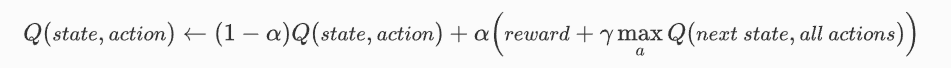

In [36]:
def learning_fun(env,alpha = 0.1,gamma =0.6, epsilon = 0.1,episods = 100000):
    # Initialize the q table
  q_table = np.zeros([env.observation_space.n, env.action_space.n])

  # For plotting metrics
  all_epochs = []
  all_penalties = []

  for i in range(1, episods):
      state = env.reset()

      epochs, penalties, reward, = 0, 0, 0
      done = False
      
      while not done:
          if random.uniform(0, 1) < epsilon:
              action = env.action_space.sample() # Explore action space
          else:
              action = np.argmax(q_table[state]) # Exploit learned values

          next_state, reward, done, info = env.step(action) 
          
          old_value = q_table[state, action]
          next_max = np.max(q_table[next_state])
      
          new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
          q_table[state, action] = new_value

          if reward == -10:
              penalties += 1

          state = next_state
          epochs += 1
          
      if i % 100 == 0:
          clear_output(wait=True)
          print(f"Episode: {i}")

  print("Training finished.\n")
  avg_time_step = epochs / episods
  return q_table,avg_time_step,penalties

#Function to evaluate the agent

In [37]:
def evaluate_agent(env,q_table):
  """Evaluate agent's performance after Q-learning"""

  total_epochs, total_penalties = 0, 0
  episodes = 100

  for _ in range(episodes):
      state = env.reset()
      epochs, penalties, reward = 0, 0, 0
      
      done = False
      
      while not done:
          action = np.argmax(q_table[state])
          state, reward, done, info = env.step(action)

          if reward == -10:
              penalties += 1

          epochs += 1

      total_penalties += penalties
      total_epochs += epochs

      avg_time_step = total_epochs / episodes
      avg_penalities = total_penalties / episodes

  print(f"Results after {episodes} episodes:")
  print(f"Average timesteps per episode: {avg_time_step}")
  print(f"Average penalties per episode: {avg_penalities}")
  return avg_time_step,avg_penalities

In [38]:
def grid_search(env):
  alpha = [0.2,0.4,0.6,0.8]
  gamma = [0.1,0.3,0.5,0.7,0.9]
  all_steps = []

  for i in alpha:
    for j in gamma:
        Q,avg_time_step,penalities = learning_fun(env,alpha=i,gamma = j,episods=10000)
        l = {"alpha":i,"gamma":j,"avg_time_step":avg_time_step,'penalities':penalities}
        all_steps.append(l)
  
  all_penalities = []
  all_avg_time_steps = []
  for i in all_steps:
    penalitie = i.get('penalities')
    avg_time_step = i.get('avg_time_step')
    all_penalities.append(penalitie)
    all_avg_time_steps.append(avg_time_step)
  

  if all_avg_time_steps.index(min(all_avg_time_steps)) == all_penalities.index(min(all_penalities)):
    return all_steps[all_penalities.index(min(all_penalities))]
  else:
    return all_steps[all_avg_time_steps.index(min(all_avg_time_steps))]

In [66]:
env = gym.make("Taxi-v3").env
# env = gym.make('FrozenLake-v0')
 
#Initializing the Q-matrix
Q = np.zeros((env.observation_space.n, env.action_space.n))

In [40]:
#SARSA Learning
reward = learning_SARSA_fun(Q,env)

Streaming output truncated to the last 5000 lines.
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R

In [59]:
print(reward)

0


In [76]:
#Visualizing the Q-matrix after SARSA llearning
print(Q)

defaultdict(<function q_greedy_Learning.<locals>.<lambda> at 0x7f37b4016170>, {251: array([  0.13624579,  -9.29409121,   4.82961211,   8.        ,
       -15.03182703, -11.73830343]), 351: array([ -8.97249838,   6.99998556,  -9.36064095,  -1.38814114,
       -10.9584    ,  -6.95508236]), 451: array([ -9.        ,   5.62066659,  -9.3789312 ,  -9.06240054,
       -12.        , -11.93474969]), 151: array([  6.98972775, -10.27454461,  -9.69631841, -10.01888539,
       -10.56      , -12.        ]), 271: array([-9.66383995,  3.68827746, -9.66094502,  7.        , -6.60000001,
       -8.10554182]), 371: array([ -6.66650278,   5.99184553,  -9.96604996, -10.01116198,
       -14.57116198, -15.01022147]), 471: array([-10.2       ,   4.32856442, -10.24232696, -10.2       ,
       -11.92873422, -13.54373091]), 171: array([  5.99963903,  -9.74114164,  -9.89024838,  -0.93586286,
       -17.90448584, -14.68878014]), 291: array([-10.24442499,  -9.85607374,  -9.8976    ,   5.562672  ,
       -17.0475393 

In [67]:
#custom learning
Q = q_greedy_Learning(env, 1000)

In [75]:
#Visualizing the Q-matrix after custom learning
print(Q)

defaultdict(<function q_greedy_Learning.<locals>.<lambda> at 0x7f37b4016170>, {251: array([  0.13624579,  -9.29409121,   4.82961211,   8.        ,
       -15.03182703, -11.73830343]), 351: array([ -8.97249838,   6.99998556,  -9.36064095,  -1.38814114,
       -10.9584    ,  -6.95508236]), 451: array([ -9.        ,   5.62066659,  -9.3789312 ,  -9.06240054,
       -12.        , -11.93474969]), 151: array([  6.98972775, -10.27454461,  -9.69631841, -10.01888539,
       -10.56      , -12.        ]), 271: array([-9.66383995,  3.68827746, -9.66094502,  7.        , -6.60000001,
       -8.10554182]), 371: array([ -6.66650278,   5.99184553,  -9.96604996, -10.01116198,
       -14.57116198, -15.01022147]), 471: array([-10.2       ,   4.32856442, -10.24232696, -10.2       ,
       -11.92873422, -13.54373091]), 171: array([  5.99963903,  -9.74114164,  -9.89024838,  -0.93586286,
       -17.90448584, -14.68878014]), 291: array([-10.24442499,  -9.85607374,  -9.8976    ,   5.562672  ,
       -17.0475393 

In [44]:
perefect_values = grid_search(env)

Episode: 9900
Training finished.



In [45]:
perefect_values

{'alpha': 0.2, 'avg_time_step': 0.0007, 'gamma': 0.5, 'penalities': 0}

#Evaluate the model

In [46]:
avg_time_step,avg_penalities = evaluate_agent(env,Q)

Results after 100 episodes:
Average timesteps per episode: 13.11
Average penalties per episode: 0.0


#Tune alpha, gamma using a decay over episodes

In [47]:
#suppose alpha = 0.2, gamma = 0.4 and episodes = 1000
q_table,avg_time_step,penalties = learning_fun(env,alpha = 0.2,gamma=0.4, episods=1000)

Episode: 900
Training finished.



In [48]:
print("Average time step : ",avg_time_step,", penalities : ",penalties)

Average time step :  0.023 , penalities :  1


In [49]:
#suppose alpha = 0.7, gamma = 0.1 and episodes = 10000
q_table,avg_time_step,penalties = learning_fun(env,alpha = 0.7,gamma=0.1, episods=10000)

Episode: 9900
Training finished.



In [50]:
print("Average time step : ",avg_time_step,", penalities : ",penalties)

Average time step :  0.0012 , penalities :  0


In [51]:
#suppose alpha = 0.7, gamma = 0.5 and episodes = 100000
q_table,avg_time_step,penalties = learning_fun(env,alpha = 0.7,gamma=0.5, episods=100000)

Episode: 99900
Training finished.



In [52]:
print("Average time step : ",avg_time_step,", penalities : ",penalties)

Average time step :  0.00016 , penalities :  0


In [53]:
#suppose alpha = 0.8, gamma = 0.1 and episodes = 100000
q_table,avg_time_step,penalties = learning_fun(env,alpha = 0.8,gamma=0.1, episods=100000)

Episode: 99900
Training finished.



In [54]:
print("Average time step : ",avg_time_step,", penalities : ",penalties)

Average time step :  0.00015 , penalities :  1


#Deep Q-Learning

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizer_v2.adam import Adam

!pip install keras-rl2
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 718 kB/s 


In [56]:
# Building the environment
environment_name = 'MountainCar-v0'
env = gym.make(environment_name)
np.random.seed(0)
env.seed(0)
  
# Extracting the number of possible actions
num_actions = env.action_space.n

In [57]:
agent = Sequential()
agent.add(Flatten(input_shape =(1, ) + env.observation_space.shape))
agent.add(Dense(16))
agent.add(Activation('relu'))
agent.add(Dense(num_actions))
agent.add(Activation('linear'))

In [58]:
# Building the model to find the optimal strategy
strategy = EpsGreedyQPolicy()
memory = SequentialMemory(limit = 10000, window_length = 1)
dqn = DQNAgent(model = agent, nb_actions = num_actions,
               memory = memory, nb_steps_warmup = 10,
target_model_update = 1e-2, policy = strategy)
dqn.compile(Adam(lr = 1e-3), metrics =['mae'])
  
# Visualizing the training 
dqn.fit(env, nb_steps = 5000, verbose = 3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 5000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


  200/5000: episode: 1, duration: 1.983s, episode steps: 200, steps per second: 101, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.570 [0.000, 2.000],  loss: 0.335722, mae: 0.428798, mean_q: -0.168237
  400/5000: episode: 2, duration: 1.987s, episode steps: 200, steps per second: 101, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.670 [0.000, 2.000],  loss: 0.119257, mae: 0.926773, mean_q: -1.084286
  600/5000: episode: 3, duration: 2.444s, episode steps: 200, steps per second:  82, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.800 [0.000, 2.000],  loss: 0.038789, mae: 1.732323, mean_q: -2.427226
  800/5000: episode: 4, duration: 4.811s, episode steps: 200, steps per second:  42, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.840 [0.000, 2.000],  loss: 0.032734, mae: 2.698008, mean_q: -3.928163
 1000/5000: episode: 5, duration: 3.979s, episode steps: 200, st